## Problem 3: How far did people travel? (8 points)

During this task, the aim is to calculate the (air-line) distance in meters that each social media user in the data set prepared in *Problem 2* has travelled in-between the posts. We’re interested in the Euclidean distance between subsequent points generated by the same user.

For this, we will need to use the `userid` column of the data set `kruger_posts.shp` that we created in *Problem 2*.

Answer the following questions:
- What was the shortest distance a user travelled between all their posts (in meters)?
- What was the mean distance travelled per user (in meters)?
- What was the maximum distance a user travelled (in meters)?

---


### a) Read the input file and re-project it

- Read the input file `kruger_points.shp` into a geo-data frame `kruger_points`
- Transform the data from WGS84 to an `EPSG:32735` projection (UTM Zone 35S, suitable for South Africa). This CRS has *metres* as units.

In [3]:
import pathlib 
import pandas as pd
import geopandas as gpd

NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "static" / "data"
input_file = DATA_DIRECTORY / "kruger_points.shp"

kruger_points = gpd.read_file(input_file)
kruger_points.head()


,lat,lon,timestamp,userid,geometry
0,-24.980792,31.484633,2015-07-07 03:02,66487960,POINT (31.48463 -24.98079)
1,-25.499225,31.508906,2015-07-07 03:18,65281761,POINT (31.50891 -25.49922)
2,-24.342578,30.930866,2015-03-07 03:38,90916112,POINT (30.93087 -24.34258)
3,-24.854614,31.519718,2015-10-07 05:04,37959089,POINT (31.51972 -24.85461)
4,-24.921069,31.520836,2015-10-07 05:19,27793716,POINT (31.52084 -24.92107)


In [4]:
kruger_points = kruger_points.to_crs("EPSG:32735")

In [5]:
# NON-EDITABLE CODE CELL FOR TESTING YOUR SOLUTION

# Check the data
kruger_points.head()

,lat,lon,timestamp,userid,geometry
0,-24.980792,31.484633,2015-07-07 03:02,66487960,POINT (952912.890 7229683.258)
1,-25.499225,31.508906,2015-07-07 03:18,65281761,POINT (953433.223 7172080.632)
2,-24.342578,30.930866,2015-03-07 03:38,90916112,POINT (898955.144 7302197.408)
3,-24.854614,31.519718,2015-10-07 05:04,37959089,POINT (956927.218 7243564.942)
4,-24.921069,31.520836,2015-10-07 05:19,27793716,POINT (956794.955 7236187.926)


In [6]:
# NON-EDITABLE CODE CELL FOR TESTING YOUR SOLUTION

# Check that the crs is correct after re-projecting (should be epsg:32735)
import pyproj
assert kruger_points.crs == pyproj.CRS("EPSG:32735")

### b) Group the data by user id

Group the data by `userid` and store the grouped data in a variable `grouped_by_users`

In [7]:
grouped_by_users = kruger_points.groupby('userid')

In [8]:
# NON-EDITABLE CODE CELL FOR TESTING YOUR SOLUTION

# Check the number of groups:
assert len(grouped_by_users.groups) == kruger_points["userid"].nunique(), "Number of groups should match number of unique users!"

In [9]:
grouped_by_users

### c) Create `shapely.geometry.LineString` objects for each user connecting the points from oldest to most recent

There are multiple ways to solve this problem (see the [hints for this exercise](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-2/exercise-2.html). You can use, for instance, a dictionary or an empty GeoDataFrame to collect data that is generated using the steps below:

- Use a for-loop to iterate over the grouped object. For each user’s data: 
    - [sort](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html) the rows by timestamp 
    - create a `shapely.geometry.LineString` based on the user’s points

**CAREFUL**: Remember that every LineString needs at least two points. Skip users who have less than two posts.

Store the results in a `geopandas.GeoDataFrame` called `movements`, and remember to assign a CRS.

In [19]:
from shapely.geometry import LineString
users = kruger_points["userid"].unique()
lines = []
user_ids = []
for user in users:
  user_df = kruger_points[kruger_points['userid'] == user]
  if len(user_df) < 2:
    continue
  user_df = user_df.sort_values(by='timestamp', ascending=True)
  line = LineString(list(zip(user_df['lon'], user_df['lat'])))
  lines.append(line)
  user_ids.append(user)
print(len(lines))


9026


In [22]:
movements = gpd.GeoDataFrame({'userid': user_ids, 'geometry': lines})
movements = movements.set_crs("EPSG:32735", allow_override=True)


In [23]:
# NON-EDITABLE CODE CELL FOR TESTING YOUR SOLUTION

# Check the result
print(type(movements))
print(movements.crs)

movements

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:32735


,userid,geometry
0,65281761,"LINESTRING (31.450 -25.427, 31.509 -25.499, 31..."
1,90916112,"LINESTRING (30.931 -24.343, 30.931 -24.343, 30..."
2,37959089,"LINESTRING (31.522 -24.921, 31.521 -24.921, 31..."
3,27793716,"LINESTRING (31.401 -24.786, 31.402 -24.860, 31..."
4,88751696,"LINESTRING (31.687 -24.044, 31.687 -24.048)"
...,...,...
9021,40992775,"LINESTRING (30.958 -24.351, 30.958 -24.351)"
9022,87980026,"LINESTRING (31.521 -24.922, 31.524 -24.922, 31..."
9023,99778679,"LINESTRING (30.959 -24.259, 30.895 -24.205)"
9024,65850367,"LINESTRING (31.727 -25.411, 31.748 -25.351)"


<AxesSubplot: >

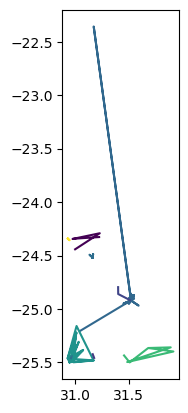

In [25]:
movements[0:10].plot(column='userid')

### d) Calculate the distance between all posts of a user

- Check once more that the CRS of the data frame is correct
- Compute the lengths of the lines, and store it in a new column called `distance`

In [26]:
# ADD YOUR OWN CODE HERE
movements['distance'] = movements['geometry'].length

In [27]:
# NON-EDITABLE CODE CELL FOR TESTING YOUR SOLUTION

#Check the output
movements.head()

,userid,geometry,distance
0,65281761,"LINESTRING (31.450 -25.427, 31.509 -25.499, 31...",1.633636
1,90916112,"LINESTRING (30.931 -24.343, 30.931 -24.343, 30...",0.044455
2,37959089,"LINESTRING (31.522 -24.921, 31.521 -24.921, 31...",7.854558
3,27793716,"LINESTRING (31.401 -24.786, 31.402 -24.860, 31...",0.207887
4,88751696,"LINESTRING (31.687 -24.044, 31.687 -24.048)",0.003833


### e) Answer the original questions

You should now be able to quickly find answers to the following questions: 
- What was the shortest distance a user travelled between all their posts (in meters)? (store the value in a variable `shortest_distance`)
- What was the mean distance travelled per user (in meters)? (store the value in a variable `mean_distance`)
- What was the maximum distance a user travelled (in meters)? (store the value in a variable `longest_distance`)

In [28]:
# Function for calculating the shortest distance
from shapely.geometry import Point
import numpy as np
def shortest_distance(linestring):
    points = list(linestring.coords)
    distances = [Point(points[i]).distance(Point(points[i + 1])) for i in range(len(points) - 1)]
    return min(distances) if distances else np.nan

In [29]:
movements['shortest_distance'] = movements['geometry'].apply(shortest_distance)

In [31]:
# Function for calculating the longest distance
def longest_distance(linestring):
    points = list(linestring.coords)
    distances = [Point(points[i]).distance(Point(points[i + 1])) for i in range(len(points) - 1)]
    return max(distances) if distances else np.nan

In [32]:
movements['longest_distance'] = movements['geometry'].apply(longest_distance)
movements.head()

,userid,geometry,distance,shortest_distance,longest_distance
0,65281761,"LINESTRING (31.450 -25.427, 31.509 -25.499, 31...",1.633636,0.093173,0.443286
1,90916112,"LINESTRING (30.931 -24.343, 30.931 -24.343, 30...",0.044455,0.000000,0.022218
2,37959089,"LINESTRING (31.522 -24.921, 31.521 -24.921, 31...",7.854558,0.000000,2.586622
3,27793716,"LINESTRING (31.401 -24.786, 31.402 -24.860, 31...",0.207887,0.074004,0.133884
4,88751696,"LINESTRING (31.687 -24.044, 31.687 -24.048)",0.003833,0.003833,0.003833


In [33]:
# Function for calculating the mean distance
def mean_distance(linestring):
    points = list(linestring.coords)
    distances = [Point(points[i]).distance(Point(points[i + 1])) for i in range(len(points) - 1)]
    return np.mean(distances) if distances else np.nan

In [34]:
movements['mean_distance'] = movements['geometry'].apply(mean_distance)
movements.head()

,userid,geometry,distance,shortest_distance,longest_distance,mean_distance
0,65281761,"LINESTRING (31.450 -25.427, 31.509 -25.499, 31...",1.633636,0.093173,0.443286,0.272273
1,90916112,"LINESTRING (30.931 -24.343, 30.931 -24.343, 30...",0.044455,0.000000,0.022218,0.002021
2,37959089,"LINESTRING (31.522 -24.921, 31.521 -24.921, 31...",7.854558,0.000000,2.586622,0.090282
3,27793716,"LINESTRING (31.401 -24.786, 31.402 -24.860, 31...",0.207887,0.074004,0.133884,0.103944
4,88751696,"LINESTRING (31.687 -24.044, 31.687 -24.048)",0.003833,0.003833,0.003833,0.003833


### f) Save the movements in a file

Save the `movements` into a new Shapefile called `movements.shp` inside the `data` directory.

In [35]:
# ADD YOUR OWN CODE HERE
movements.to_file(DATA_DIRECTORY / "movements.shp")

/var/folders/3b/tt4qp8jn3_zg_0fpwkxc61f80000gp/T/ipykernel_9965/3813005815.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  movements.to_file(DATA_DIRECTORY / "movements.shp")


In [36]:
# NON-EDITABLE CODE CELL FOR TESTING YOUR SOLUTION

assert (DATA_DIRECTORY / "movements.shp").exists()


---

# Fantastic job!

That’s all for this week! 